C:\Users\GlebP\AppData\Local\Temp\ipykernel_22724\527546802.py:6: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter
MovieWriter ffmpeg unavailable; using Pillow instead.


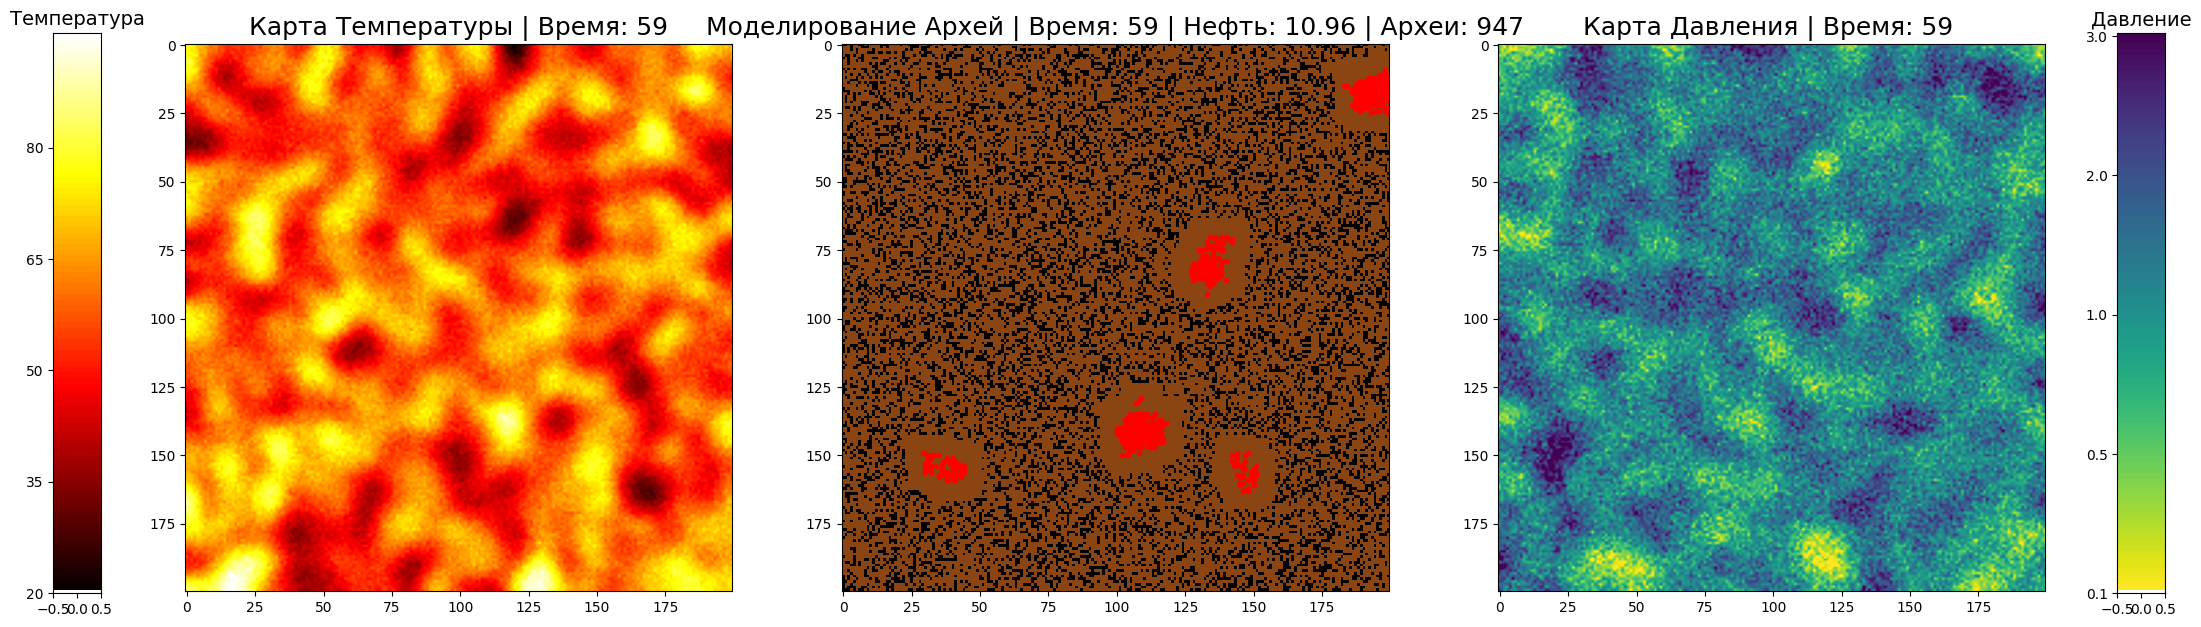

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
import random
from scipy.ndimage.filters import gaussian_filter

# Параметры
GRID_SIZE = 200  # Размер сетки
INITIAL_ARCHEA_COUNT = 5  # Начальное количество архей (измените для тестирования)
OIL_DENSITY = 0.3  # Плотность нефти в сетке (0-1)
ARCHEA_MOVEMENT_PROBABILITY = 0.5  # Вероятность движения архей
ARCHEA_REPRODUCTION_PROBABILITY = 0.1  # Вероятность размножения архей
CONSUMPTION_RADIUS = 6  # Радиус потребления нефти вокруг архей
STARVATION_FRAMES = 20  # Количество кадров без нефти, после которого археи умирают
# Условия для выживания архей
OPTIMAL_TEMPERATURE = (30, 60)  # Оптимальная температура в градусах Цельсия
OPTIMAL_PRESSURE = (0.5, 2)  # Оптимальное давление в атмосферах
# Создание сетки
grid = np.random.rand(GRID_SIZE, GRID_SIZE) < OIL_DENSITY  # Создание сетки с нефтью

# Создание карты температуры и давления с плавным распределением
temperature_map = gaussian_filter(np.random.uniform(20, 80, (GRID_SIZE, GRID_SIZE)), sigma=5)  # Температура от 20 до 80°C
pressure_map = gaussian_filter(np.random.uniform(0.1, 3, (GRID_SIZE, GRID_SIZE)), sigma=5)  # Давление от 0.1 до 3 атм
# Функция для инициализации позиций архей на основе плотности нефти и условий
def initialize_archea_positions(initial_count, grid, temperature_map, pressure_map):
    oil_density_map = np.zeros_like(grid, dtype=float)
    
    # Вычисление плотности нефти вокруг каждой ячейки
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if grid[x, y]:  # Если есть нефть
                # Подсчет окружающих ячеек с нефтью в пределах небольшого радиуса
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        if 0 <= x + dx < GRID_SIZE and 0 <= y + dy < GRID_SIZE:
                            oil_density_map[x + dx, y + dy] += 1

    # Получение позиций с максимальной плотностью нефти
    oil_positions = np.argwhere(oil_density_map > 0)
    
    # Фильтрация позиций по условиям температуры и давления
    suitable_positions = []
    for pos in oil_positions:
        x, y = pos
        if (OPTIMAL_TEMPERATURE[0] <= temperature_map[x, y] <= OPTIMAL_TEMPERATURE[1] and
                OPTIMAL_PRESSURE[0] <= pressure_map[x, y] <= OPTIMAL_PRESSURE[1]):
            suitable_positions.append(pos)

    # Если недостаточно подходящих позиций, выбросить ошибку
    if len(suitable_positions) == 0:
        raise ValueError("Нет подходящих позиций для спавна архей.")
    
    # Случайный выбор уникальных начальных позиций из подходящих позиций
    selected_indices = np.random.choice(len(suitable_positions), size=min(initial_count, len(suitable_positions)), replace=False)
    return np.array(suitable_positions)[selected_indices]
# Инициализация позиций архей
archea_positions = initialize_archea_positions(INITIAL_ARCHEA_COUNT, grid, temperature_map, pressure_map)

# Создание фигуры и осей для анимации
fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(24, 8))
ax1.set_title("Карта Температуры", fontsize=14)
ax2.set_title("Карта Давления", fontsize=14)
ax3.set_title("Моделирование Архей", fontsize=14)

cmap_temp = plt.get_cmap('hot')  # Цвета для температуры (теплая палитра)
cmap_archea = ListedColormap(['saddlebrown', 'black'])  # Цвета для археи
# Отображение карты температуры
temp_plot = ax1.imshow(temperature_map, cmap=cmap_temp, interpolation='bilinear')

# Отображение карты давления
pressure_plot = ax2.imshow(pressure_map, interpolation='bilinear')

# Отображение сетки с нефтью и археями
oil_plot = ax3.imshow(grid, cmap=cmap_archea, interpolation='nearest')
archea_plot, = ax3.plot(archea_positions[:, 1], archea_positions[:, 0], 'ro', markersize=3)  # Меньший маркер архей

# Добавление полос для отображения температуры и давления
temp_bar = fig.add_axes([0.07, 0.15, 0.02, 0.7])
temp_bar.set_title("Температура", fontsize=14)
temp_bar.imshow(np.linspace(80, 20, 100).reshape(100, 1), cmap=cmap_temp, aspect='auto')
temp_bar.set_yticks([100, 80, 60, 40, 20])
temp_bar.set_yticklabels([20, 35, 50, 65, 80])

pressure_bar = fig.add_axes([0.93, 0.15, 0.02, 0.7])
pressure_bar.set_title("Давление", fontsize=14)
pressure_bar.imshow(np.linspace(0.1, 3, 100).reshape(100, 1), aspect='auto')
pressure_bar.set_yticks([100, 75, 50, 25, 0])
pressure_bar.set_yticklabels([0.1, 0.5, 1.0, 2.0, 3.0])

# Добавление счетчиков голода и здоровья для каждой археи
starvation_counters = np.zeros(len(archea_positions), dtype=int)
health_counters = np.zeros(len(archea_positions), dtype=int)  # Счетчик здоровья

# Функция для расчета и отображения статистики (без изменений)
def calculate_statistics(grid, archea_positions):
    oil_count = np.sum(grid)  # Подсчет нефти
    archaea_count = len(archea_positions)  # Подсчет архей
    return oil_count, archaea_count

# Функция для обновления кадра анимации
def animate(frame):
    global archea_positions, grid, temperature_map, pressure_map, starvation_counters, health_counters, graph
    # Обновление карт температуры и давления с плавной анимацией
    temperature_map += np.random.uniform(-0.5, 0.5, (GRID_SIZE, GRID_SIZE)) / 10
    pressure_map += np.random.uniform(-0.1, 0.1, (GRID_SIZE, GRID_SIZE)) / 10

    # Обновление отображения карты температуры
    temp_plot.set_array(temperature_map)
    # Обновление отображения карты давления
    pressure_plot.set_array(pressure_map)

    # Проверка условий для выживания архей
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        if (temperature_map[x, y] < OPTIMAL_TEMPERATURE[0] or temperature_map[x, y] > OPTIMAL_TEMPERATURE[1] or
                pressure_map[x, y] < OPTIMAL_PRESSURE[0] or pressure_map[x, y] > OPTIMAL_PRESSURE[1]):
            health_counters[i] += 1  # Увеличение счетчика здоровья
        else:
            health_counters[i] = 0  # Сброс счетчика здоровья

    # Удаление архей, если здоровье ухудшилось
    dead_archea_indices = np.where(health_counters >= 10)[0]
    if dead_archea_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archea_indices, axis=0)
        starvation_counters = np.delete(starvation_counters, dead_archea_indices)
        health_counters = np.delete(health_counters, dead_archea_indices)

    # Движение архей
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < ARCHEA_MOVEMENT_PROBABILITY:
            # Выбор случайного направления
            direction = random.randint(0, 3)
            if direction == 0 and x < GRID_SIZE - 1:  # Двигаться вправо
                x += 1
            elif direction == 1 and x > 0:  # Двигаться влево
                x -= 1
            elif direction == 2 and y < GRID_SIZE - 1:  # Двигаться вниз
                y += 1
            elif direction == 3 and y > 0:  # Двигаться вверх
                y -= 1
            archea_positions[i] = (x, y)

    # Размножение архей
    new_archea_positions = []
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < ARCHEA_REPRODUCTION_PROBABILITY:
            # Выбор случайного направления для новых архей
            direction = random.randint(0, 3)
            if direction == 0 and x < GRID_SIZE - 1:  # Двигаться вправо
                new_archea_positions.append((x + 1, y))
            elif direction == 1 and x > 0:  # Двигаться влево
                new_archea_positions.append((x - 1, y))
            elif direction == 2 and y < GRID_SIZE - 1:  # Двигаться вниз
                new_archea_positions.append((x, y + 1))
            elif direction == 3 and y > 0:  # Двигаться вверх
                new_archea_positions.append((x, y - 1))

    new_archea_positions = np.array(new_archea_positions)

    if new_archea_positions.size > 0:
        archea_positions = np.vstack((archea_positions, new_archea_positions))
        starvation_counters = np.append(starvation_counters, np.zeros(len(new_archea_positions), dtype=int))
        health_counters = np.append(health_counters, np.zeros(len(new_archea_positions), dtype=int))

    # Потребление нефти вокруг архей
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        found_oil = False
        for dx in range(-CONSUMPTION_RADIUS, CONSUMPTION_RADIUS + 1):
            for dy in range(-CONSUMPTION_RADIUS, CONSUMPTION_RADIUS + 1):
                nx = x + dx
                ny = y + dy
                if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and grid[nx, ny]:
                    grid[nx, ny] = False
                    found_oil = True
                    break
            if found_oil:
                break

        if found_oil:
            starvation_counters[i] = 0
        else:
            starvation_counters[i] += 1

    dead_archea_indices = np.where(starvation_counters >= STARVATION_FRAMES)[0]
    if dead_archea_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archea_indices, axis=0)
        starvation_counters = np.delete(starvation_counters, dead_archea_indices)
        health_counters = np.delete(health_counters, dead_archea_indices)

    # Обновление отображения сетки с нефтью и археями
    oil_plot.set_data(grid)
    archea_plot.set_data(archea_positions[:, 1], archea_positions[:, 0])

    # Статистика
    stats = calculate_statistics(grid, archea_positions)
    ax1.set_title(f"Карта Температуры | Время: {frame}", fontsize=18)
    ax2.set_title(f"Карта Давления | Время: {frame} ", fontsize=18)
    ax3.set_title(f"Моделирование Архей | Время: {frame} | Нефть: {stats[0] / 1000:.2f} | Археи: {stats[1]}", fontsize=18)
    return temp_plot, pressure_plot, oil_plot, archea_plot
ani = animation.FuncAnimation(fig, animate, frames=60, interval=300, blit=True)
ani.save('animation.gif')
plt.show()